In [10]:
from fileIO import *
from constants import *
import numpy as np
import matplotlib.pyplot as plt

"""
Import 2D cuDisc run (steadyTD.cpp)
"""

sim = CuDiscModel("../outputs/isoPD2D_gas_init")

# Load in grids, densities and temperatures

g = sim.grid
sizes = sim.load_grain_sizes()
gas, dust = sim.load_all_prim_data()
temp = sim.load_all_temp_data()
#opacs = sim.load_opacity()
ts = sim.load_output_times()

/u/srwmills/cuDisc/codes/python/fileIO.py:134: RuntimeWarning: invalid value encountered in divide
  D = np.log(mass[1:]/mass[:-1])/np.log(size[1:]/size[:-1])


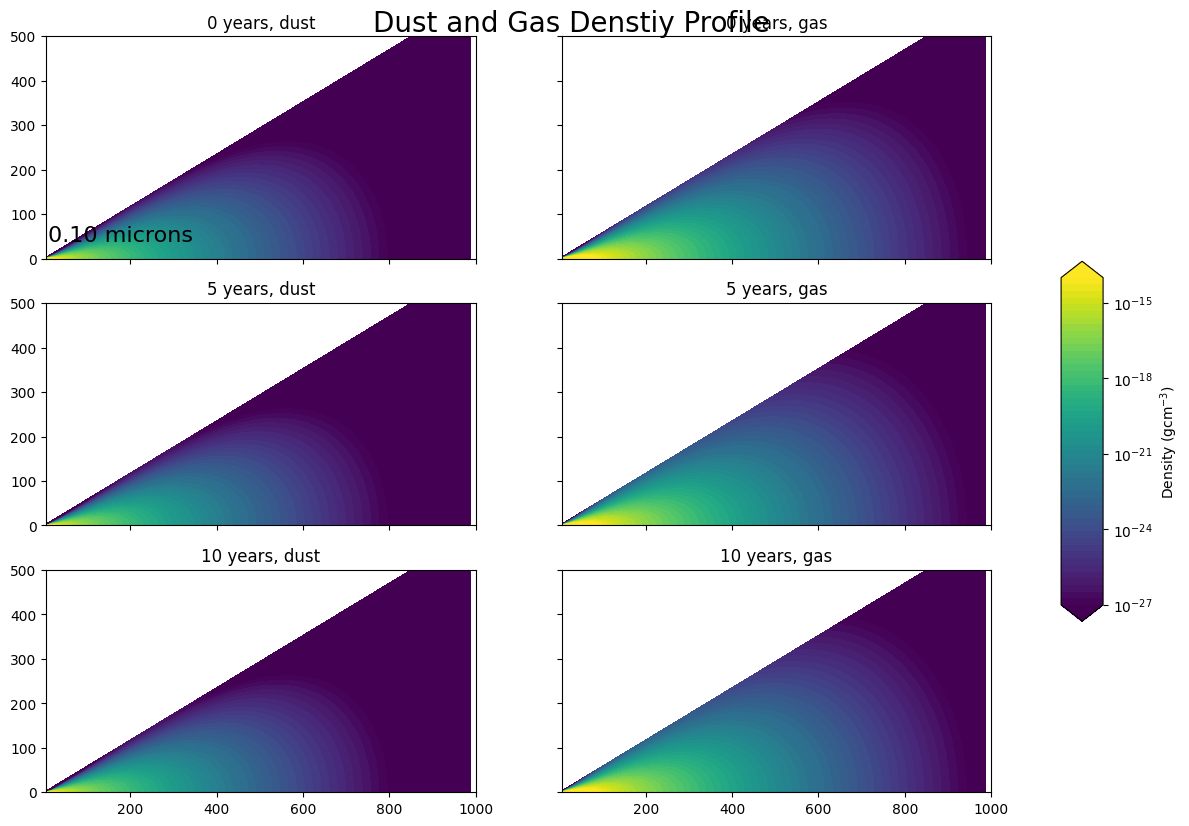

In [11]:
tsnaps = [i for i in range(0, len(ts))]
grain = 0

fig, ax = plt.subplots(len(ts), 2, figsize=(14, 3*np.size(tsnaps)), sharex=True, sharey=True)

for i in range(0, len(ts)):
    cond = ax[i,0].contourf(g.R/au, g.Z/au, np.log10(dust.rho[i,:,:,0]), np.linspace(-27,-14,50), extend='both')
    ax[i,0].set_title('%1.0d years, dust'%(ts[i]//year))
    cong = ax[i,1].contourf(g.R/au, g.Z/au, np.log10(gas.rho[i,:,:]), np.linspace(-27,-14,50), extend='both')
    ax[i,1].set_title('%1.0d years, gas'%(ts[i]//year))

ax[0,0].text(10,40, "%1.2f microns"%(sizes.a_c[grain]*1e4), fontsize=16, c='k')

plt.xlim(5,1000)
plt.ylim(0,500)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.4])
cbar = fig.colorbar(cond, cax=cbar_ax)
cbar.set_ticks(np.arange(-27,-12,3))
cbar.set_ticklabels(["$10^{%d}$"%(x) for x in np.arange(-27,-12,3)])
cbar.set_label(r"Density (gcm$^{-3}$)")
fig.subplots_adjust(top=0.95)
fig.suptitle("Dust and Gas Denstiy Profile", size=20)

plt.show()

2.1156108150488545e-07 1.365012347592826e+41


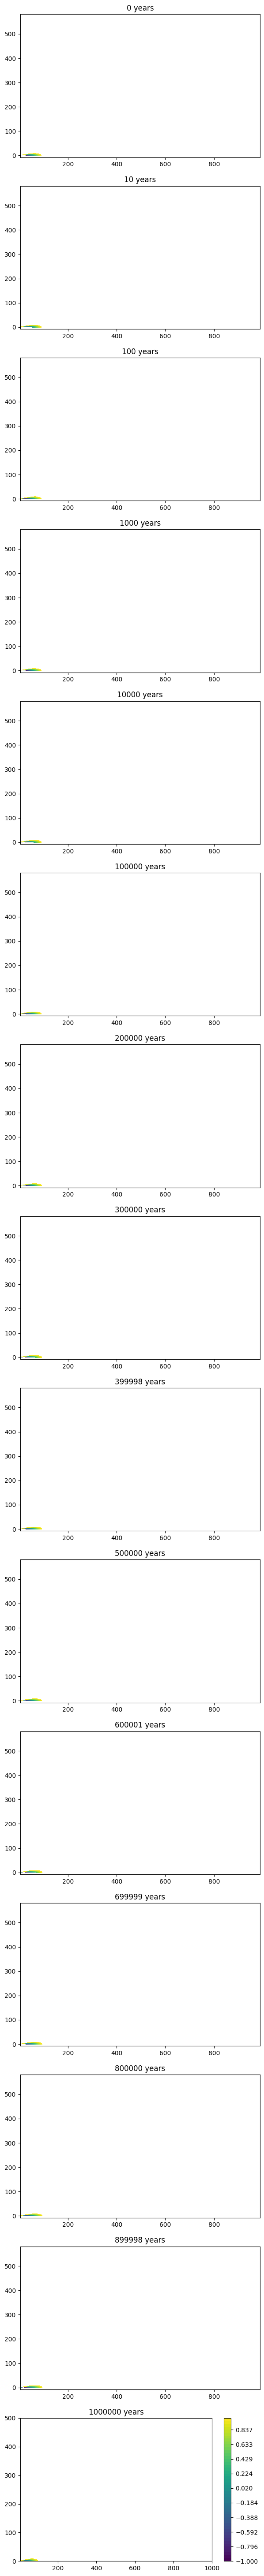

In [27]:
grain_radius = 1e-1
mu = 2.4
internal_density = 1.6

def find_cs2(temp):
    return k_B * temp.T[0,:,:] / (mu * m_H)

def stokes(g, dust, gas, temp):
    cs = np.sqrt(find_cs2(temp))[None,:,:,None]
    Omega = np.sqrt(GMsun / g.R_c) /g.R_c
    rho_g = gas.rho[:,:,:,None]
    u_rel = np.sqrt((dust.vR - gas.vR[:,:,:,None])**2 + (dust.vphi - gas.vphi[:,:,:,None])**2 + (dust.vZ - gas.vZ[:,:,:,None])**2)
    mfp = mu * m_H / (rho_g * 2e-15)
    sqrtgamma = np.sqrt(1.0 + 0.4 * mu)
    nu_mol = 1.595769122 * 0.5 * mfp * cs
    Re = 2.0 * grain_radius * u_rel / nu_mol
    M = u_rel / cs
    G = (10.0 ** (2.5 * ((Re / 312)**0.6688))) / ((1 + ((Re / 312)**0.6688)))
    H = 4.6 / (1.0 + M) + 1.7
    vC_inc = 12.0 * nu_mol / grain_radius * (1.0 + 0.15 * (Re ** 0.687) + 0.407 * u_rel * Re / (Re + 8710))
    vC_D = 2 * u_rel + (vC_inc - 2 * u_rel) * np.exp(-1.535 *sqrtgamma * G * nu_mol / (grain_radius * cs)) + H * np.exp(-grain_radius * cs / nu_mol) * cs / sqrtgamma
    return 8 * internal_density * grain_radius * Omega / (3 * rho_g * vC_D)

St = stokes(g, dust, gas, temp)

fig, ax = plt.subplots(len(tsnaps), 1, figsize=(7, 5*len(tsnaps)))

for i in range(len(tsnaps)):
    con = ax[i].contourf(g.R/au, g.Z/au, np.log10(St[tsnaps[i],:,:,0]), np.linspace(-1, 1, 50))
    ax[i].set_title('%1.0d years'%(ts[tsnaps[i]]//year))

print(np.min(St), np.max(St))

plt.ylim(0,500)
plt.xlim(5,1000)
plt.colorbar(con)
plt.show()

/tmp/ipykernel_631374/4039201356.py:5: RuntimeWarning: divide by zero encountered in log10
  con = ax[i,0].contourf(g.R/au, g.Z/au, np.log10(np.abs(dust.vR[i,:,:,0])), np.linspace(0,4,50), extend='both')
/tmp/ipykernel_631374/4039201356.py:9: RuntimeWarning: divide by zero encountered in log10
  ax[i,1].contourf(g.R/au, g.Z/au, np.log10(np.abs(dust.vZ[i,:,:,0])), np.linspace(0,4,50), extend='both')
/tmp/ipykernel_631374/4039201356.py:13: RuntimeWarning: divide by zero encountered in log10
  ax[i,2].contourf(g.R/au, g.Z/au, np.log10(speed[i,:,:,0]), np.linspace(0,4,50), extend='both')


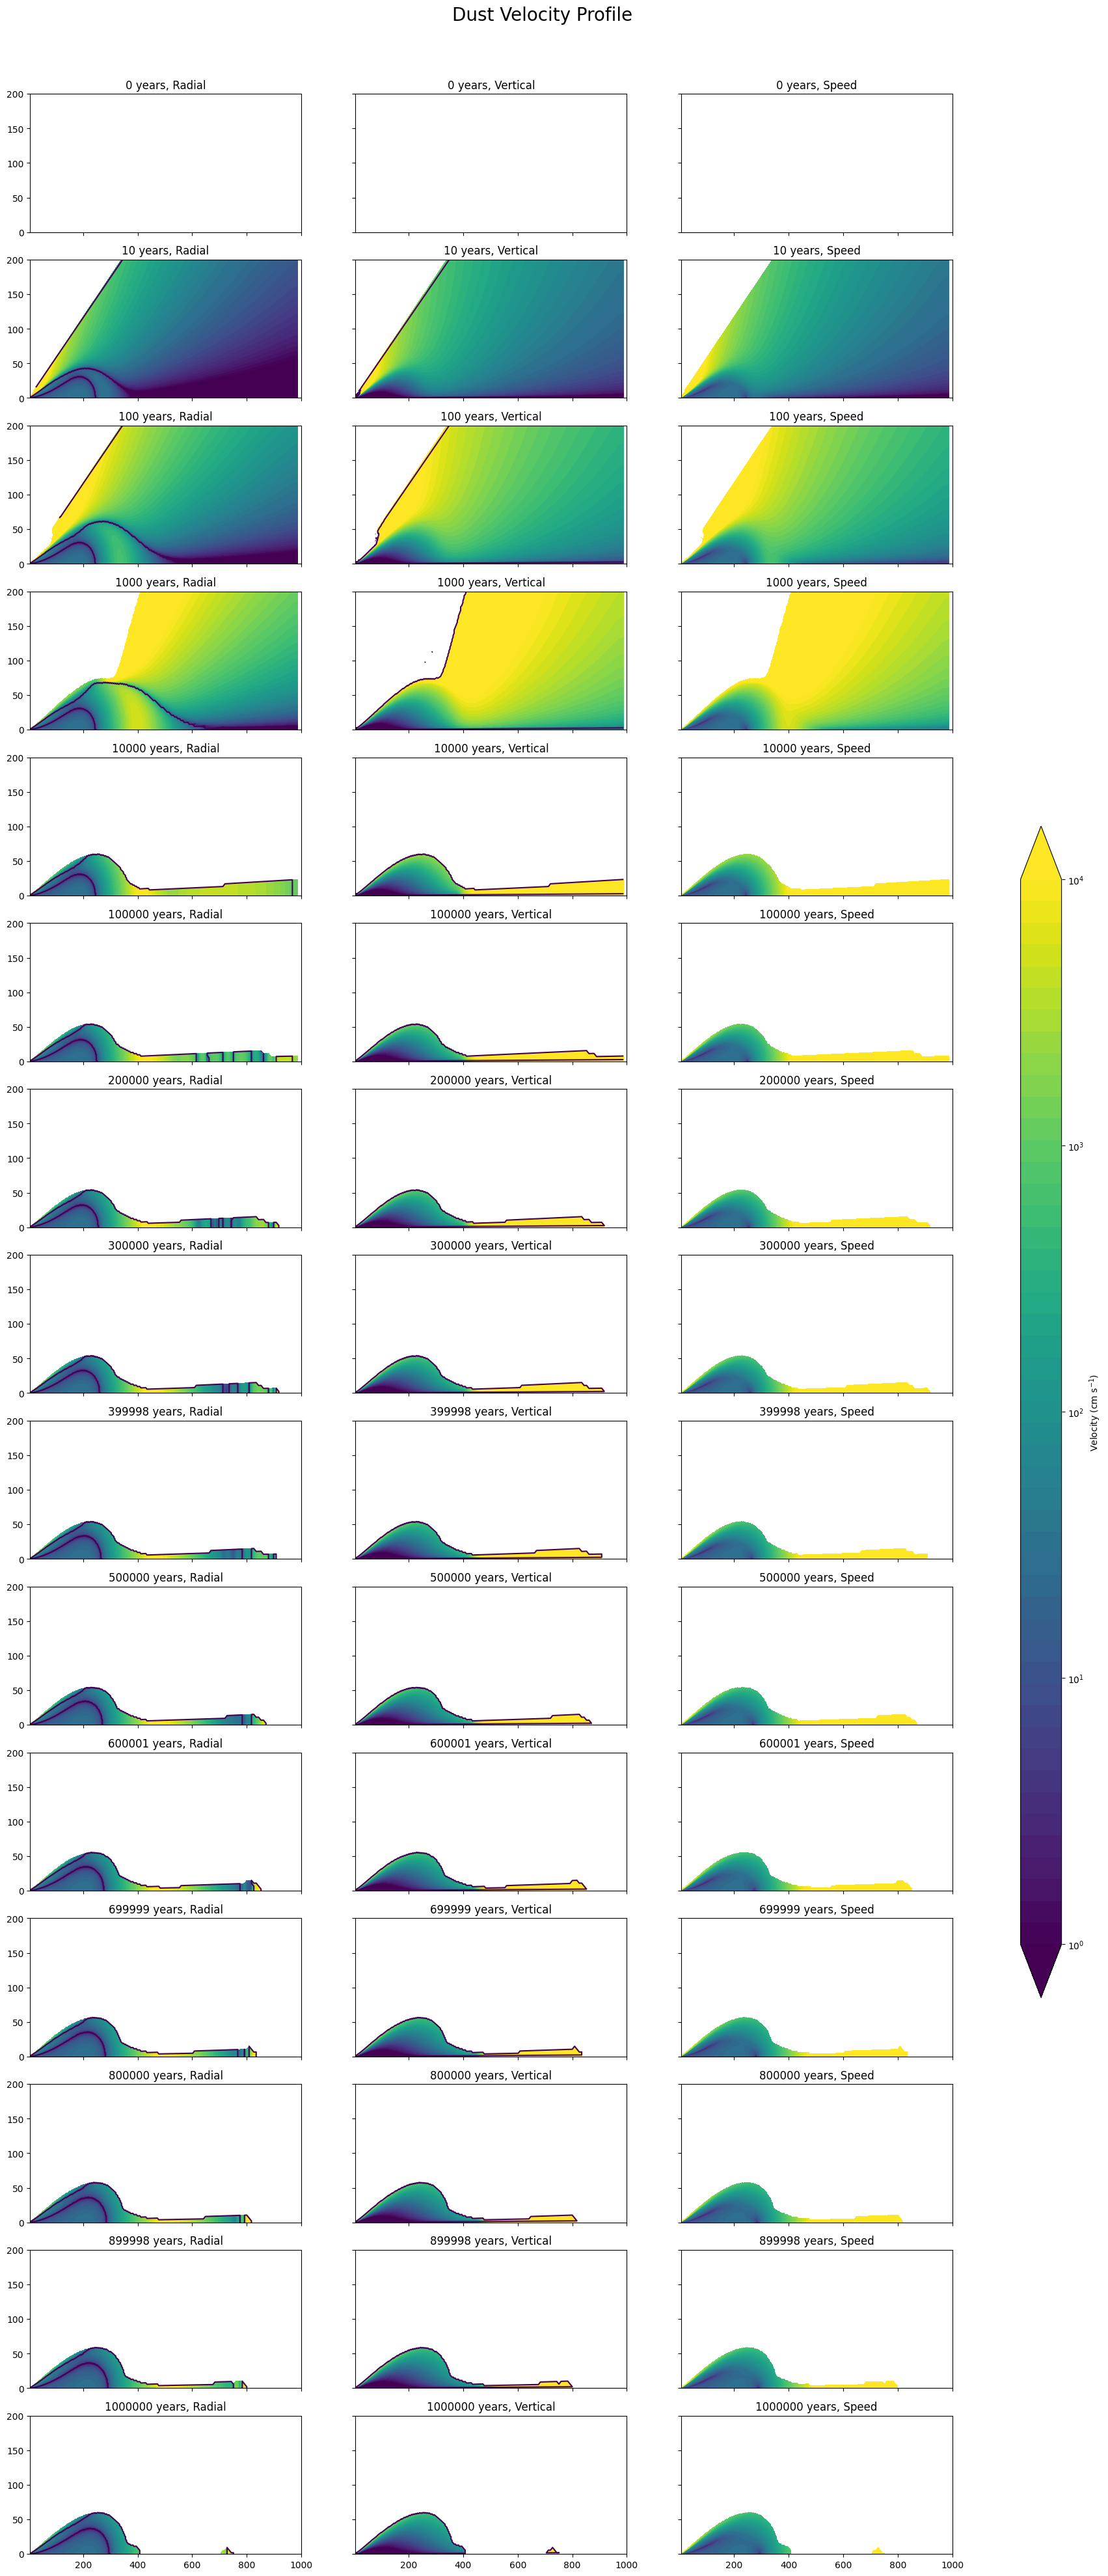

In [13]:
fig, ax = plt.subplots(len(ts), 3, figsize=(21, 3*np.size(tsnaps)), sharex=True, sharey=True)
speed = np.sqrt(dust.vZ**2 + dust.vR**2)

for i in range(0, len(ts)):
    con = ax[i,0].contourf(g.R/au, g.Z/au, np.log10(np.abs(dust.vR[i,:,:,0])), np.linspace(0,4,50), extend='both')
    ax[i,0].contour(g.R/au, g.Z/au, np.sign(dust.vR[i,:,:,0]), np.array([-1,1]))
    ax[i,0].set_title('%1.0d years, Radial'%(ts[i]//year))

    ax[i,1].contourf(g.R/au, g.Z/au, np.log10(np.abs(dust.vZ[i,:,:,0])), np.linspace(0,4,50), extend='both')
    ax[i,1].contour(g.R/au, g.Z/au, np.sign(dust.vZ[i,:,:,0]), np.array([-1,1]))
    ax[i,1].set_title('%1.0d years, Vertical'%(ts[i]//year))

    ax[i,2].contourf(g.R/au, g.Z/au, np.log10(speed[i,:,:,0]), np.linspace(0,4,50), extend='both')
    ax[i,2].set_title('%1.0d years, Speed'%(ts[i]//year))

plt.xlim(5,1000)
plt.ylim(0,200)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.4])
cbar = fig.colorbar(con, cax=cbar_ax)
cbar.set_ticks(np.linspace(0,4,num=5))
cbar.set_ticklabels(["$10^{%d}$"%(x) for x in np.linspace(0,4,num=5)])
cbar.set_label(r"Velocity (cm s$^{-1}$)")
fig.subplots_adjust(top=0.95)
fig.suptitle("Dust Velocity Profile", size=20)

plt.show()

In [14]:
sim1d = CuDiscModel("../outputs/1Ddisc")

g1d = sim1d.grid
Sig_g1d, Sig_d1d, v_d1d, v_g1d = sim1d.load1Drun()

/tmp/ipykernel_631374/3072992260.py:5: RuntimeWarning: divide by zero encountered in divide
  sig_d = 2.*np.sum(sizes.m_c[None,None,None,:] * dust.rho[:,:,2:-2,:] / np.diff(sizes.m_e[None,None,None,:]) * np.diff(Z_e[None,:,2:-2,None],axis=2), axis=2)


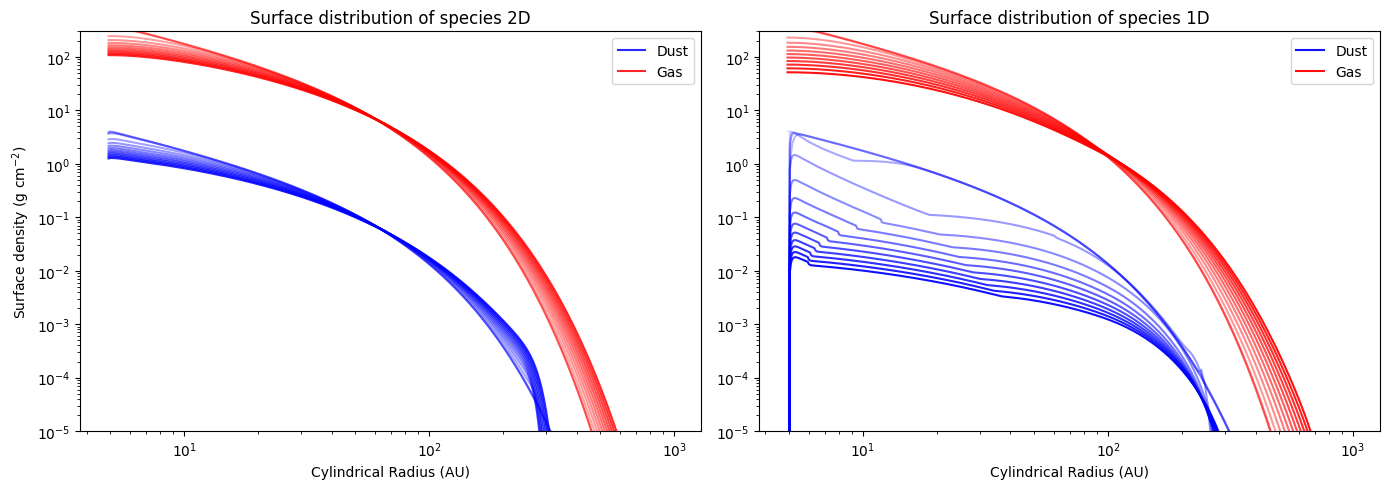

In [15]:
def calc_sig_dust(g, dust, sizes):
    sig_d_tot = np.zeros((g.R.shape[0], dust.rho.shape[0]))
    Z_e = g.R_c[:,None] * g.tan_th_e 

    sig_d = 2.*np.sum(sizes.m_c[None,None,None,:] * dust.rho[:,:,2:-2,:] / np.diff(sizes.m_e[None,None,None,:]) * np.diff(Z_e[None,:,2:-2,None],axis=2), axis=2)
    sig_d_tot = 2.*np.sum(dust.rho[:,:,2:-2,:].sum(-1) * np.diff(Z_e[None,:,2:-2]), axis=2)

    return sig_d, sig_d_tot

sig_d, Sig_d = calc_sig_dust(g, dust, sizes)

fig, ax = plt.subplots(1,2, figsize=(14,5))
for i in range(sig_d.shape[0]):
    if i==sig_d.shape[0]-1:
        ax[0].loglog(g.R[:,0]/au, Sig_d[i,:], color='b', label="Dust",alpha=0.1+i*0.8/sig_d.shape[0])
        ax[0].loglog(g.R[:,0]/au, gas.Sigma[i,:], color='r', label="Gas",alpha=0.1+i*0.8/sig_d.shape[0])

        ax[1].loglog(g1d.R_c/au, Sig_d1d[i,:], color = 'b', label="Dust", alpha = 0.1 + i*0.9/Sig_d1d.shape[0])
        ax[1].loglog(g1d.R_c/au, Sig_g1d[i,:], color = 'r', label="Gas", alpha = 0.1 + i*0.9/Sig_d1d.shape[0])
    else:
        ax[0].loglog(g.R[:,0]/au, Sig_d[i,:], color='b',alpha=0.1+i*0.8/sig_d.shape[0])
        ax[0].loglog(g.R[:,0]/au, gas.Sigma[i,:], color='r',alpha=0.1+i*0.8/sig_d.shape[0])

        ax[1].loglog(g1d.R_c/au, Sig_d1d[i,:], color = 'b', alpha = 0.1 + i*0.9/Sig_d1d.shape[0])
        ax[1].loglog(g1d.R_c/au, Sig_g1d[i,:], color = 'r', alpha = 0.1 + i*0.9/Sig_d1d.shape[0])

ax[0].set_ylim(1e-5, 300)
ax[1].set_ylim(1e-5, 300)

#plt.xlim(3,19)
ax[0].set_title("Surface distribution of species 2D")
ax[0].set_ylabel(r"Surface density (g cm$^{-2}$)")
ax[0].set_xlabel('Cylindrical Radius (AU)')
ax[0].legend()

ax[1].set_title("Surface distribution of species 1D")
ax[1].set_xlabel('Cylindrical Radius (AU)')
ax[1].legend()

plt.tight_layout()
plt.show()

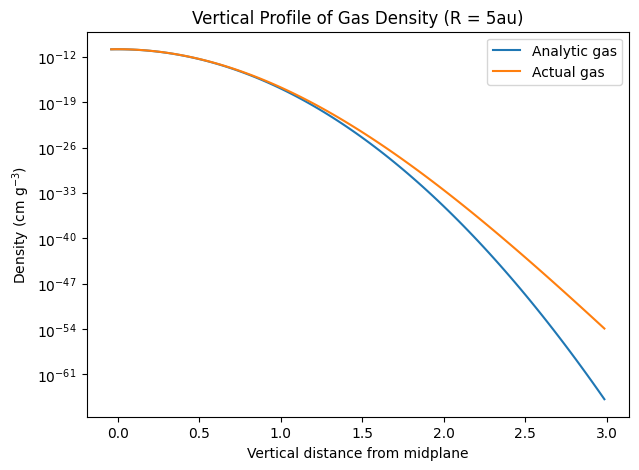

In [11]:
mu = 2.4

def find_cs2(temp):
    return k_B * temp.T[0,:,:] / (mu * m_H)

def find_gas_anal(g, temp, gas):
    cs2 = find_cs2(temp)
    rho_anal = np.zeros(np.shape(temp.T))
    H2 = np.zeros(np.shape(temp.T)[1])

    for r in range(np.shape(temp.T)[1]):
        for t in range(np.shape(temp.T)[0]):
            H2[r] = cs2[r,0] * g.R_c[r] * g.R_c[r] * g.R_c[r] / GMsun
            rho_anal[t,r,:] = gas.rho[t,r,0] * np.exp(- g.R_c[r] * g.tan_th_c * g.R_c[r] * g.tan_th_c / (2 * H2[r]))

    return rho_anal

plt.figure(figsize=(7,5))
plt.semilogy(g.Z[3,:]/au, find_gas_anal(g, temp, gas)[-1,3,:], label="Analytic gas")
plt.semilogy(g.Z[3,:]/au, gas.rho[-1,3,:], label="Actual gas")
plt.xlabel("Vertical distance from midplane")
plt.ylabel("Density (cm g$^{-3}$)")
plt.title("Vertical Profile of Gas Density (R = 5au)")
plt.legend()
plt.show()

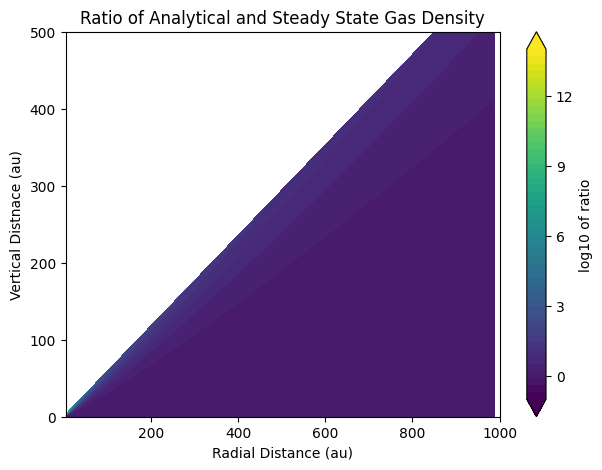

In [21]:
plt.figure(figsize=(7, 5))
plt.contourf(g.R/au, g.Z/au, np.log10(gas.rho[-1,:,:]/find_gas_anal(g, temp, gas)[-1,:,:]), np.linspace(-1,14,50), extend='both')
plt.xlim(5,1000)
plt.ylim(0,500)
plt.colorbar(ticks = np.arange(0,15,3), label="log10 of ratio")
plt.xlabel("Radial Distance (au)")
plt.ylabel("Vertical Distnace (au)")
plt.title("Ratio of Analytical and Steady State Gas Density")

plt.show()